In [152]:
from processing_functions import *
%matplotlib inline

In [153]:
# reading datasets
personal_data = pd.read_csv('./dataset/Ovarian/ovar_data_mar22_d032222.csv')
screen_data = pd.read_csv('./dataset/Ovarian/Screening/ovar_screen_data_mar22_d032222.csv')
screen_abnorm_data = pd.read_csv('./dataset/Ovarian/Screening Abnormalities/ovar_scrsub_data_mar22_d032222.csv')

## Preprocessing
For some of the datasets we determined some of the features to not be useful for analysis. For every dataset that includes `build` features. 

For personal dataset we removed all `ovar_` features since they are a direct result of the cancer diagnosis and should not be used predict cancer. 

For the screen data dataset it was determined that `examinerid_` features do not bring the value to the dataset since they represet 'Examiner ID made by concatentating center and exam ID for overall screen result.' and cannot be the cause of the cancer. We also drop all of the remaining

In [154]:
# Drop profy features
proxy_features_personal_dataset = [
    'fstcan_exitdays', # Days from trial entry (randomization) to first cancer diagnosis for participants with cancer, or to trial exit otherwise. Only cancers occuring during the trial are used to determine exit.
    'fstcan_exitstat', # Status of the participant at exit for first cancer incidence. Only cancers occuring during the trial are used to determine exit.
    'f_dthovar', # Is ovarian cancer the underlying cause of death? This conclusion is based on the information from the death certificate and death review.
    'f_codeath_cat', # Categorized underlying cause of death.
    'f_cancersite', # Underlying cause of death from cancer.
    'f_seer_death', # Underlying cause of death.
    'd_codeath_cat', # Categorized underlying cause of death.
    'd_dthovar', # Is Ovarian Cancer The Underlying Cause Of Death?
    'd_cancersite', # 
    'd_seer_death', # Underlying cause of death.
    'ph_ovar_muq', # Did the participant have a personal history of ovarian/ft/pt cancer prior to MUQ analysis entry? 
    'ph_ovar_sqx', # 
    'entrydays_muq', # 
    'ca125_src1', # 
    'ph_ovar_dhq', # 
    'dth_days', # 
    ]

proxy_features_screen_dataset = [
    'QAMETHOD',
    'tvudays_pvis1',
    'tvudays_pvis2',
    'tvudays_pvis3',
    'tvures_qvis1',
    'tvures_qvis2',
    'tvures_qvis3',
    'tvu_assess_days_q',
    'ca125ii_src', # 
    'medcomp', # 
    'ca125_src', # 
    'tvures_pvis3', # It is completely missing for non-cancer patients
]

personal_data = personal_data.drop(proxy_features_personal_dataset, axis=1)
screen_data = screen_data.drop(proxy_features_screen_dataset, axis=1)

# Remove all ovar_ features
personal_data = remove_featues_startswith(personal_data, ['ovar_', 'build'], ['ovar_cancer'])

# Remove all inad_ and examinerid_ and build_ features
screen_data = remove_featues_startswith(screen_data, ['inad_', 'examinerid', 'build'])

# Drop not useful cols and convert categorical into numerical in screen abnormalities
screen_abnorm_data = screen_abnorm_data.drop('build', axis=1)

Number of ovar_ cols: 50
['ovar_reasfoll', 'ovar_reassurv', 'ovar_reassymp', 'ovar_reasoth', 'ovar_cancer', 'ovar_intstat_cat', 'ovar_annyr', 'ovar_cancer_site', 'ovar_stage', 'ovar_stage_7e', 'ovar_stage_t', 'ovar_stage_n', 'ovar_stage_m', 'ovar_clinstage', 'ovar_clinstage_7e', 'ovar_clinstage_t', 'ovar_clinstage_n', 'ovar_clinstage_m', 'ovar_pathstage', 'ovar_pathstage_7e', 'ovar_pathstage_t', 'ovar_pathstage_n', 'ovar_pathstage_m', 'ovar_grade', 'ovar_topography', 'ovar_morphology', 'ovar_behavior', 'ovar_histtype', 'ovar_exitstat', 'ovar_exitage', 'ovar_seer', 'ovar_cancer_first', 'ovar_curative_surg', 'ovar_curative_chemo', 'ovar_primary_trt', 'ovar_num_heslide_imgs', 'ovar_has_deliv_heslide_img', 'ovar_exitdays', 'ovar_primary_trt_days', 'ovar_cancer_diagdays', 'ovar_mra_stat0', 'ovar_mra_stat1', 'ovar_mra_stat2', 'ovar_mra_stat3', 'ovar_mra_stat4', 'ovar_mra_stat5', 'ovar_eligible_bq', 'ovar_eligible_sqx', 'ovar_eligible_dhq', 'ovar_eligible_dqx']
Number of build cols: 4
['build

In [155]:
print_records_vs_unique(personal_data, 'plco_id', 'personal')
# Check the number of people with cancer
personal_data_cancer = personal_data[personal_data['ovar_cancer']==1]
print(f"Num of patients with cancer: {len(personal_data_cancer)}")
# Check the number of people without cancer
personal_data_no_cancer = personal_data[personal_data['ovar_cancer']==0]
print(f"Num of patients without cancer: {len(personal_data_no_cancer)}")

Num of records in personal dataset: 78209
Num of unique plco_id in personal dataset: 78209
Num of patients with cancer: 613
Num of patients without cancer: 77596


## Merging data into features and mean imputing


## `TODO:` should we mean impute before and after or just after? Also, should we use labeled imputation?

In [156]:
def labeled_mean_impute(df, label_df, columns, id_col, label_col):
    label_dict = {}
    df_list = []
    for label in sorted(label_df[label_col].unique()):
        label_dict[label] = label_df[label_df[label_col] == label][id_col].to_list()

    for label, id_list in label_dict.items():
        filtered_df = df[df[id_col].isin(id_list)]
        for col in columns:
            filtered_df[col] = filtered_df[col].fillna(filtered_df[col].mean())
        df_list.append(filtered_df)

    return pd.concat(df_list, axis=0)

In [157]:
personal_data = labeled_mean_impute(personal_data, personal_data, select_numeric_columns(personal_data), id_col='plco_id', label_col='ovar_cancer')

C:\Users\fedor\AppData\Local\Temp\ipykernel_145928\1703254149.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].fillna(filtered_df[col].mean())


In [158]:
# Mean impute before converting into features
screen_data = labeled_mean_impute(screen_data, personal_data, select_numeric_columns(screen_data), id_col='plco_id', label_col='ovar_cancer')
# Turn screen dataset each year into a feature
merged_data_screen = merge_df_into_features(screen_data, 'plco_id', ['study_yr'])
print_records_vs_unique(merged_data_screen, 'plco_id', 'merged_data_screen')
# Mean impute after converting into features
# merged_data_screen = labeled_mean_impute(merged_data_screen, personal_data, select_numeric_columns(merged_data_screen), id_col='plco_id', label_col='ovar_cancer')

# Drop features that are 100% missing
merged_data_screen = drop_cols_missing_percentage(100, merged_data_screen, 'merged_data_screen')

C:\Users\fedor\AppData\Local\Temp\ipykernel_145928\1703254149.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].fillna(filtered_df[col].mean())


Num of records in merged_data_screen dataset: 30849
Num of unique plco_id in merged_data_screen dataset: 30849
Removing features that are over 100% missing
0 columns were over 100 missing. This is the list of columns: []
The table of features missing over 100 percentage: 
+---------------+---------------+---------------+-------------------+
| column_name   | num_missing   | num_present   | percent_missing   |
|---------------+---------------+---------------+-------------------|
+---------------+---------------+---------------+-------------------+


In [159]:
# Mean Impute before converting into new features
screen_abnorm_data = labeled_mean_impute(screen_abnorm_data, personal_data, select_numeric_columns(screen_abnorm_data), id_col='plco_id', label_col='ovar_cancer')
# Turn screen dataset each year into a feature
make_unique_over_cols = ['study_yr', 'side', 'source', 'VISIT', 'sbcd']
merged_data_screen_abd = merge_df_into_features(screen_abnorm_data, 'plco_id', make_unique_over_cols)
print_records_vs_unique(merged_data_screen_abd, 'plco_id', 'screen_abnorm_data')
# Mean Impute after converting into new features
# merged_data_screen_abd = labeled_mean_impute(merged_data_screen_abd, personal_data, select_numeric_columns(merged_data_screen_abd), id_col='plco_id', label_col='ovar_cancer')

# Drop features that are 100% missing
merged_data_screen_abd = drop_cols_missing_percentage(100, merged_data_screen_abd, 'merged_data_screen_abd', show_missing=False)

# Convert Categorical features
merged_data_screen_abd = merged_data_screen_abd.replace({'L': 0, 'R': 1, 'TVU': 0, 'TVQ': 1})

C:\Users\fedor\AppData\Local\Temp\ipykernel_145928\1703254149.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].fillna(filtered_df[col].mean())


Num of records in screen_abnorm_data dataset: 6992
Num of unique plco_id in screen_abnorm_data dataset: 6992
Removing features that are over 100% missing
The table of features missing over 100 percentage: 


## Merging Datasets

## `TODO:` should we dismiss people who do not have records in screen dataset. Abnormalities dataset? Run tests on all of the combinations of merges and imputations? 

In [160]:
# Merge cancer patients dataset with screen dataset and see missing values
merge_type_cancer = 'left'
merge_type_no_cancer = 'inner'
merged_data_cancer = personal_data_cancer.merge(merged_data_screen, on='plco_id', how=merge_type_cancer)
# merged_data_cancer = merged_data_cancer.merge(merged_data_screen_abd, on='plco_id', how='left')
merged_data_no_cancer = personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how=merge_type_no_cancer)
# merged_data_no_cancer = merged_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how=merge_type_no_cancer)

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

In [161]:

# Labeled Mean Impute before converting into new features
merged_data_cancer = labeled_mean_impute(merged_data_cancer, personal_data, select_numeric_columns(merged_data_cancer), id_col='plco_id', label_col='ovar_cancer')
merged_data_no_cancer = labeled_mean_impute(merged_data_no_cancer, personal_data, select_numeric_columns(merged_data_no_cancer), id_col='plco_id', label_col='ovar_cancer')

In [162]:
x = pd.concat([merged_data_cancer, merged_data_no_cancer], axis=0)

# Mean Impute before converting into new features
# x = mean_impute(x, select_numeric_columns(x))
y = x['ovar_cancer']
x = x.drop(personal_data.columns, axis=1)
# x = x.drop(['ovar_cancer', 'plco_id'], axis=1)
oversampling = SMOTE()
x, y = oversampling.fit_resample(x, y)


In [164]:
len(x.columns)

396

In [165]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [166]:
# x = x.reset_index()
# y = y.reset_index()

## `TODO:` run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

## `TODO:` run experiments with other classifiers and remove the top feature every time. Store the efficacy of the top feature, its value, accuracy, confusion matrix

## `TODO:` for predicting the probability of getting over a particular time span. Should I exclude people who got cancer later or put them into the group who did not get cancer. 

## `TODO:` https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

## `TODO:` Run model purele on family history variables vs purely on screen variables. 

DecisionTreeClassifier
   precision  recall  f1-score  support
0        1.0     1.0       1.0   6054.0
1        1.0     1.0       1.0   6167.0
ROC AUC score: 1.0
Accuracy Score: 1.0


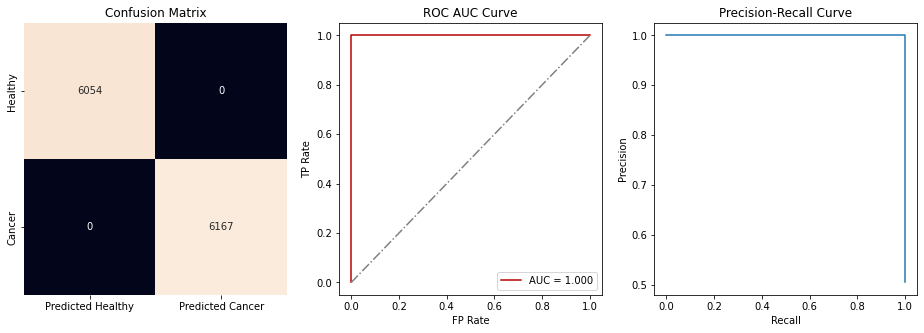

['phycons__study_yr_4']
+----+---------------------+---------------------+--------------+--------------+------------+-------------+----------+------------+
|    | top_feature         |   num_features_used |   importance |   tree_depth |   accuracy |   precision |   recall |   f1-score |
|----+---------------------+---------------------+--------------+--------------+------------+-------------+----------+------------|
|  0 | phycons__study_yr_4 |                   1 |            1 |            1 |          1 |           1 |        1 |          1 |
+----+---------------------+---------------------+--------------+--------------+------------+-------------+----------+------------+


In [167]:
from sklearn.linear_model import LogisticRegression, LinearRegression
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy', random_state= 0),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'gini', n_estimators= 200, random_state= 0),
    # 'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
# trial_x = x[top_100_features[:50]]
trial_x = x
plot_tree = False
df_feature_importance_tree = None
df_top_feature_importances = []
drop_n_features = 1
for i in range(drop_n_features):
    X_train, X_test, y_train, y_test = train_test_split(trial_x, y, test_size = 0.2, random_state = 42)
    auc_dict = {}
    accuracy_dict = {}
    top_feature_importance = []
    for classifier_type, classifier in classifiers.items():
        print(classifier_type)
        auc, accuracy = run_classifier(classifier, X_train, X_test, y_train, y_test)
        if classifier_type == 'DecisionTreeClassifier':
            fn=X_train.columns
            if plot_tree:
                cn=['no cancer', 'cancer']
                fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
                tree.plot_tree(classifier,
                    feature_names = fn, 
                    class_names=cn,
                    filled = True)
                plt.show()
            feature_importances = pd.DataFrame(classifier.feature_importances_,
                                index = fn,
                                columns=['importance']).sort_values('importance', 
                                                                    ascending=False)
            feature_importances['feature'] = feature_importances.index
            feature_importances = feature_importances[['feature', 'importance']]
            feature_importances.to_csv('./feature_importance.csv')
            top_feature_importance.append(feature_importances.iloc[0]['feature'])
            y_pred = classifier.predict(X_test)
            y_prob = classifier.predict_proba(X_test)[:,1]
            # TODO: boundary and confusion matrix
            df_top_feature_importances.append({
                'top_feature': feature_importances.iloc[0]['feature'],
                # 'boundary': 0,
                'num_features_used': len(feature_importances[feature_importances['importance'] > 0]),
                'importance': round(feature_importances.iloc[0]['importance'], 3),
                'tree_depth': classifier.tree_.max_depth,
                'accuracy': accuracy,
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1-score': f1_score(y_test, y_pred),
            })
            if df_feature_importance_tree is not None:
                df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='feature', how='outer', suffixes=[f'_tiral_{i}', f'_tiral_{i+1}'])
            else:
                df_feature_importance_tree = feature_importances
            # print_df(feature_importances)
        auc_dict[classifier_type] = auc
        accuracy_dict[classifier_type] = accuracy
    trial_x = trial_x.drop(top_feature_importance, axis=1)
    print(top_feature_importance)

# df_feature_importance_tree = df_feature_importance_tree[df_feature_importance_tree['importance'] > 0]
# print_df(df_feature_importance_tree)
print_df(pd.DataFrame(df_top_feature_importances))
pd.DataFrame(df_top_feature_importances).to_csv(f'./top_{drop_n_features}_features_decision_tree.csv')

In [168]:

pd.DataFrame(df_top_feature_importances).to_csv('./top_features_decision_tree.csv')

In [169]:
pd.DataFrame(df_top_feature_importances)['top_feature'].to_list()

['phycons__study_yr_4']

In [170]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    XGBClassifier(),
    LogisticRegression(max_iter=200)
]
# Calculate years before cancer
def f_score(X_train, X_test, y_train, y_test, classifiers):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")
# f_score(X_train, X_test, y_train, y_test, classifiers)

In [171]:
def select_using_model():
    sel = SelectFromModel(XGBClassifier())
    sel.fit(x,y)

In [172]:
def select_using_score_func():
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # what are scores for the features
    features_scores = pd.DataFrame(x.columns)
    features_scores['scores'] = fs.scores_
    features_scores = features_scores.sort_values('scores', ascending=False)
    features_scores.to_csv('./feature_selection/all_features_new_cols__mean_imputed.csv')

In [173]:
# Determine on which features to use mean imputation and on which ones to replace with -1

 The initial dataset had 181 variables (Appendix 1). Variables were ranked by their F-score, which is the harmonic mean of precision and recall, with those with an F-score closest to 1.0 demonstrating high correlation with treatment success [10]. Experts in the treatment of BPH also selected variables for inclusion into the models irrespective of the F-Score, these variables, plus those with a high F-Score were selected for inclusion in initial model development.. The actual variables used by our models were a subset of these, and the number in any given fold and subgroup was dynamically determined by treating this as a hyper-parameter and tuning it as described below.